# Unisolar Projet: Modeling
---

## Imports

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Loading data

In [2]:
df_preprocess = pd.read_csv('preprocessed_data.csv', index_col='Timestamp', parse_dates=['Timestamp'])

In [3]:
df_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61343 entries, 2020-01-01 00:15:00 to 2021-09-30 23:45:00
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SolarGeneration   61343 non-null  float64
 1   AirTemperature    61343 non-null  float64
 2   RelativeHumidity  61343 non-null  float64
 3   WindSpeed         61343 non-null  float64
 4   WindDirection     61343 non-null  object 
dtypes: float64(4), object(1)
memory usage: 2.8+ MB


In [4]:
df_preprocess.head()

,SolarGeneration,AirTemperature,RelativeHumidity,WindSpeed,WindDirection
Timestamp,,,,,
2020-01-01 00:15:00,0.0,13.860000,50.200000,15.28,S
2020-01-01 00:30:00,0.0,13.593333,51.600000,13.60,SE
2020-01-01 00:45:00,0.0,13.400000,53.000000,12.88,SE
2020-01-01 01:00:00,0.0,13.193333,54.866667,13.60,S
2020-01-01 01:15:00,0.0,13.200000,56.200000,14.80,S


## Train Test Split

We will first create a train/validation/test split on the data.

In [48]:
def train_valid_test_split(df: pd.DataFrame, train_timestamp: str, test_timestamp: str) -> tuple:
    """
    Splits the DataFrame into training, validation, and test sets based on timestamp values: training for timestamp < train_timestamp,
    validation for train_timestamp <= timestamp < test_timestamp and test for test_timestamp <= timestamp.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - train_timestamp (str): The timestamp value used to split data into the training set.
    - test_timestamp (str): The timestamp value used to split data into the test set.

    Returns:
    tuple: A tuple containing X_train, y_train, X_valid, y_valid, X_test, y_test.

    - X_train (DataFrame): Features for the training set.
    - y_train (Series): Target variable for the training set.
    - X_valid (DataFrame): Features for the validation set.
    - y_valid (Series): Target variable for the validation set.
    - X_test (DataFrame): Features for the test set.
    - y_test (Series): Target variable for the test set.

    Example:
    X_train, y_train, X_valid, y_valid, X_test, y_test = train_test_valid_split(data, '2020-01-01', '2021-03-01')
    """    
    X_train = df[df.index < train_timestamp].copy()
    y_train = X_train.pop('SolarGeneration')
    
    X_valid = df[(df.index >= train_timestamp) & (df.index < test_timestamp)].copy()
    y_valid = X_valid.pop('SolarGeneration')
    
    X_test = df[df.index >= test_timestamp].copy()
    y_test = X_test.pop('SolarGeneration')
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [49]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df_preprocess, "2021", "2021-07")

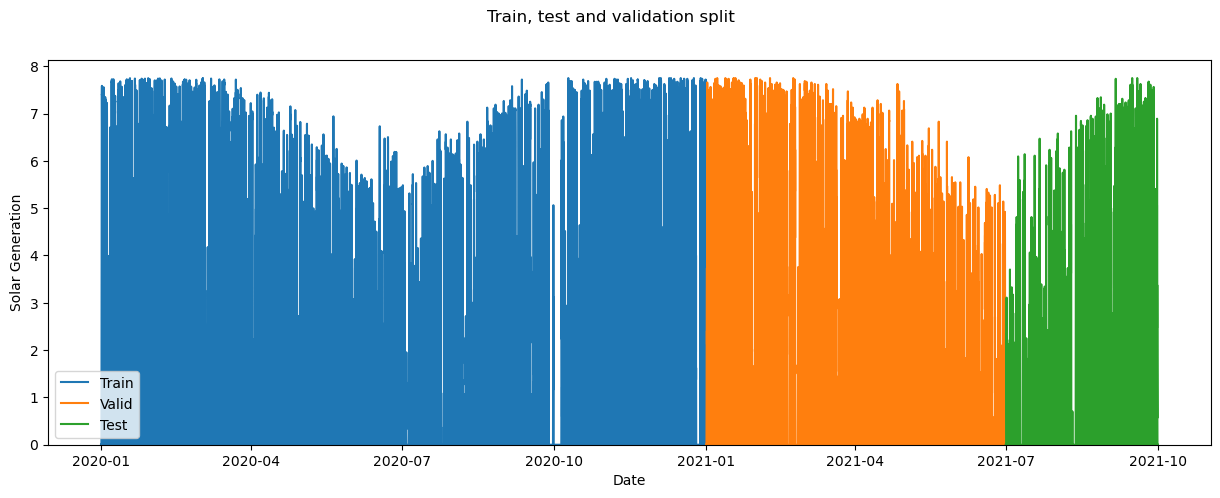

In [50]:
fig, ax = plt.subplots(1, figsize=(15,5))
ax.plot(y_train, label='Train')
ax.plot(y_valid, label='Valid')
ax.plot(y_test, label='Test')
ax.legend(loc='lower left')
ax.set_ylabel('Solar Generation')
ax.set_xlabel('Date')
ax.set_ylim(0)
fig.suptitle("Train, test and validation split");

## Preprocessing

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), 'WindDirection')
    re
])